# Fine-Tuning for Image Classification on CIFAR-10
This notebook demonstrates transfer learning and fine-tuning for image classification using CIFAR-10.

### Steps:
1. Define a CIFAR-10 wrapper that removes classes.
2. Train a small CNN on the modified dataset.
3. Fine-tune the CNN on the full CIFAR-10 dataset.
4. Fine-tune a pretrained ResNet model on CIFAR-10.


## Step 1: Define a Wrapper for CIFAR-10
We will modify the CIFAR-10 dataset by removing one class.

In [314]:
import torch
from tqdm import tqdm, trange  # To show the progress bar

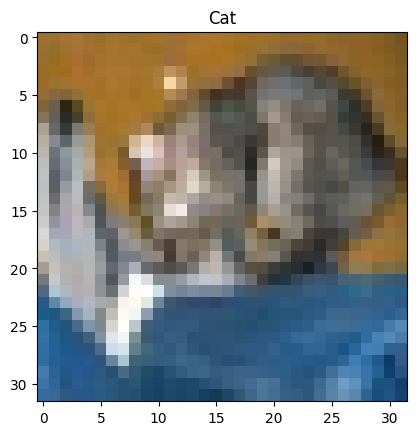

In [ ]:
from torchvision.datasets import CIFAR10

cifar10_classes = [
    "Airplane",   # 0
    "Automobile", # 1
    "Bird",       # 2
    "Cat",        # 3
    "Deer",       # 4
    "Dog",        # 5
    "Frog",       # 6
    "Horse",      # 7
    "Ship",       # 8
    "Truck"       # 9
]


full_test_set = CIFAR10('data',train=False,download=True)


x,y = full_test_set[0]

plt.imshow(x)
plt.title(cifar10_classes[y])
plt.show()

Let us define a `CIFAR10WithoutClasses` class that inherits from `CIFAR10` and removes selected classes of samples.

In [ ]:
class CIFAR10WithoutClasses(CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, removed_classes=[]):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.removed_classes = removed_classes
        self.indices = [i for i, label in enumerate(self.targets) if label not in removed_classes]
        
        # Create a label mapping (shift labels down if they are higher than removed_class)
        self.label_map = {label: new_label for new_label, label in enumerate(sorted(set(self.targets) - set(removed_classes)))}

    def __getitem__(self, index):
        real_index = self.indices[index]
        img, target = super().__getitem__(real_index)
        target = self.label_map[target]
        return img, target

    def __len__(self):
        return len(self.indices)

Define the transforms

In [ ]:
import torchvision.transforms as transforms


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data Augmentation for Training Set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    test_transform,
])

Define datasets and split train in train and val with a 80-20 split.

In [ ]:
removed_classes = [3,8]

full_trainset = CIFAR10WithoutClasses(root='./data', train=True, download=True, transform=train_transform, removed_classes=removed_classes)
test_set = CIFAR10WithoutClasses(root='./data', train=False, download=True, transform=test_transform, removed_classes=removed_classes)

train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

train_set, val_set = torch.utils.data(full_trainset, [train_size, val_size])


print(f"Training Samples: {len(train_set)}, Validation Samples: {len(val_set)}, Test Samples: {len(test_set)}")


Training Samples: 32000, Validation Samples: 8000, Test Samples: 8000


Define dataloader with batch_size of 64.

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# DataLoaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

Implement a function that shows a batch of data

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils

# Function to display a grid of images from the test set
def show_batch(dataloader,title=''):
    images, _ = next(iter(dataloader))  # Get a batch of test images

    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=1, normalize=True)

    # Convert to NumPy and plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.title(title)
    plt.show()

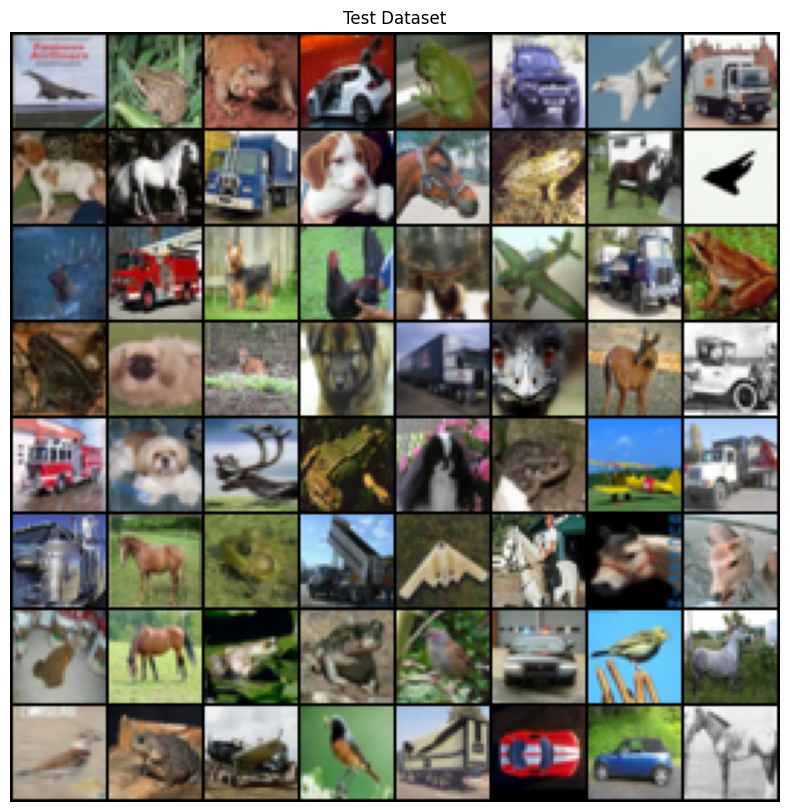

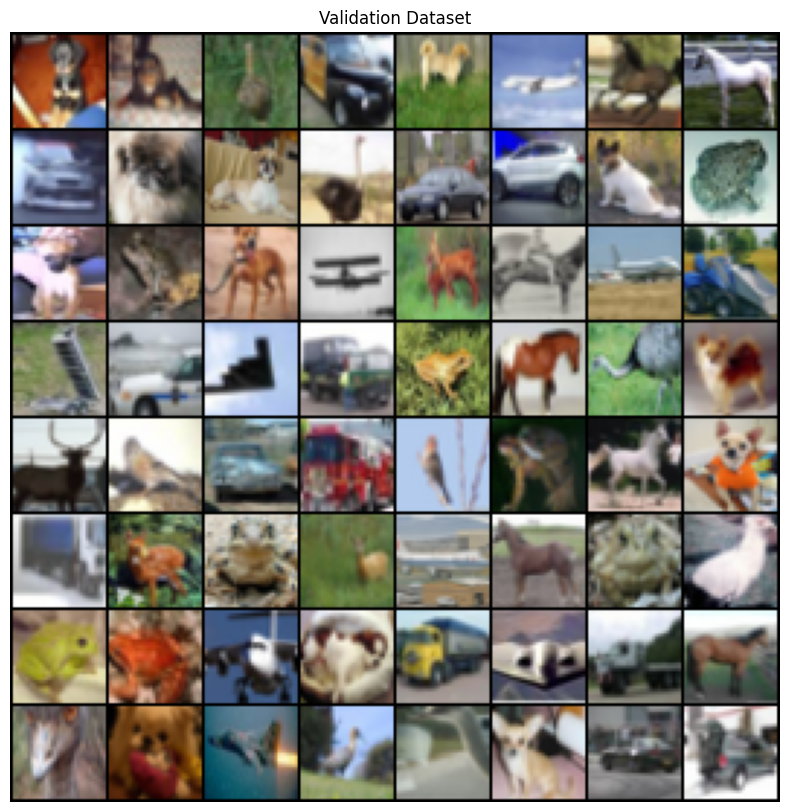

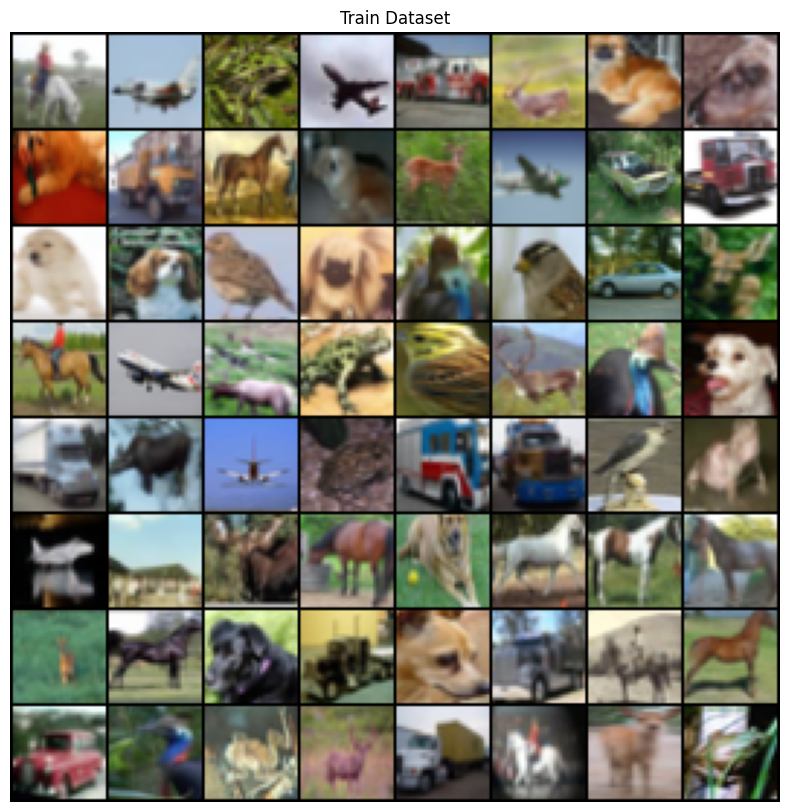

In [317]:
show_batch(test_loader, "Test Dataset")
show_batch(val_loader, "Validation Dataset")
show_batch(train_loader, "Train Dataset")


## Step 2: Define and Train a Small CNN
We will define a simple convolutional neural network and train it on the modified dataset.

In [318]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Implement a function `train_epoch` that does trains the model for one epoch. Remember to set the model in training mode. This function should return `epoch_loss` and `epoch_accuracy`.

In [319]:
def train_epoch(model, data_loader, optimizer, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train() # Important! Set the model in evaluation mode

    for (x, y) in tqdm(data_loader, desc="Training", leave=False): # load batch of data

        # push batch to device
        x = x.to(device)
        y = y.to(device)

        # compute prediction
        y_pred = model(x)

        # compute loss
        loss = loss_fn(y_pred, y)
        epoch_loss += loss.item()

        # compute accuracy and possibly other metrics
        acc = calculate_accuracy(y_pred, y)
        epoch_acc += acc.item()

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)



Implement a function `eval_epoch` that does evaluates the model for one epoch. Remember to set the model in evaluation mode (and to disable gradient tracking). This function should return `epoch_loss` and `epoch_accuracy`.

In [320]:
def eval_epoch(model, data_loader, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval() # Important! Set the model in evaluation mode

    with torch.inference_mode(): # disable gradient tracking

        for (x, y) in tqdm(data_loader, desc="Evaluating", leave=False): # load batch of data

            # push batch to device
            x = x.to(device)
            y = y.to(device)

            # compute predictions
            y_pred = model(x)

            # compute metrics
            loss = loss_fn(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Define a function `train_and_test` that takes the model, parameters to optimize, data loaders and trains the model for `num_epochs` epochs with `CrossEntropyLoss` and `Adam` optimizer with weight decay. It should also save the model with highest validation accuracy / lowest validation loss and reload it to test it.

In [ ]:
import time

def train_and_test(model, parameters, train_loader, val_loader, test_loader, device, num_epochs=5, file_name_suffix = ''):
    best_valid_loss = float('inf')
    best_valid_acc = 0
    best_valid_loss_epoch = 0

    suffix = ('_' + file_name_suffix) if file_name_suffix else ''
    best_model_file_name = f'best_model{suffix}.pth'

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(parameters, lr=0.001, weight_decay=1e-4), 

    model.to(device)

    # evaluate it to assert that the forward is ok
    _, _ = eval_epoch(model, test_loader, loss_fn, device)
    
    # Loop over the epochs
    for epoch in range(num_epochs):
        start_time = time.monotonic()  # Track the start time for each epoch

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)

        # Validation phase
        valid_loss, valid_acc = eval_epoch(model, val_loader, loss_fn, device)

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_loss_epoch = epoch
            best_valid_acc = valid_acc
            
            torch.save(model.state_dict(), best_model_file_name)

        # Time taken for the epoch
        epoch_time = time.monotonic() - start_time

        # Print the results of the current epoch
        print(f'Epoch: {epoch+1:02} | Time: {epoch_time:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

    print(f'Saved model from epoch {best_valid_loss_epoch} (val loss: {best_valid_loss:.3f} | val acc: {best_valid_acc*100:.2f}%)')

    # load best performing model
    model.load_state_dict(torch.load(best_model_file_name))

    # evaluate it on the test dataset
    test_loss, test_acc = eval_epoch(model, test_loader, loss_fn, device)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    return model



### The model

Define a SimpleCNN model with 4 Convolutional Layers, an `AdaptiveAvgPool2d` and 2 dense classification layer in the end.

In [322]:
import torch.nn as nn

def ConvLayer(in_channels, out_channels, kernel_size=3, pool_size=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
    )

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Feature extraction part (4 ConvLayers)
        self.feature_extraction = nn.Sequential(
            ConvLayer(3, 32),  # 3x32x32 → 32x16x16
            ConvLayer(32, 64),  # 32x16x16 → 64x8x8
            ConvLayer(64, 128),  # 64x8x8 → 128x4x4
            ConvLayer(128, 256)  # 128x4x4 → 256x2x2
        )

        # Global Average Pooling (output size: 256x1x1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Smaller classifier with a lightweight fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)  # Output layer with num_classes
        )

    def forward(self, x):
        x = self.feature_extraction(x)  # Pass through Conv layers
        x = self.global_avg_pool(x)  # Global Average Pooling (256x1x1)
        x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, 256)
        x = self.classifier(x)  # Pass through fully connected layers
        return x


# Example usage: Create model for 9-class classification
model = SimpleCNN(num_classes=9)
print(model)

SimpleCNN(
  (feature_extraction): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential

This is a function that counts the number of total and trainable parameters 

In [323]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "total": total,
        "trainable": trainable,
        }

In [324]:
print(count_parameters(model))
print(count_parameters(model.feature_extraction))
print(count_parameters(model.classifier))

{'total': 423433, 'trainable': 423433}
{'total': 389376, 'trainable': 389376}
{'total': 34057, 'trainable': 34057}


Choose the device we want to use

In [325]:
device_str = "cpu"
if torch.cuda.is_available():
  # Cuda / Nvidia
  device_str = "cuda"
elif torch.backends.mps.is_built():
  # Metal / Apple Silicon
  device_str = "mps"

device = torch.device(device_str)
print(f'Selected device: "{device}"')

Selected device: "mps"


In [ ]:
EPOCHS = 20

# redefine this here so we can re-execute this
model = SimpleCNN(num_classes=9)

train_and_test(model,
               model.parameters(),
               train_loader,
               val_loader,
               test_loader,
               device,
               num_epochs=EPOCHS
           )

Epoch: 01 | Time: 12.42s
	Train Loss: 1.288 | Train Acc: 52.02%
	Val. Loss: 1.147 | Val. Acc: 61.10%


Epoch: 02 | Time: 11.77s
	Train Loss: 0.946 | Train Acc: 66.50%
	Val. Loss: 0.935 | Val. Acc: 66.49%


Epoch: 03 | Time: 11.60s
	Train Loss: 0.824 | Train Acc: 71.28%
	Val. Loss: 0.768 | Val. Acc: 73.25%


Epoch: 04 | Time: 11.64s
	Train Loss: 0.746 | Train Acc: 74.42%
	Val. Loss: 0.761 | Val. Acc: 73.75%


Epoch: 05 | Time: 11.55s
	Train Loss: 0.693 | Train Acc: 76.47%
	Val. Loss: 0.656 | Val. Acc: 76.21%


Epoch: 06 | Time: 11.50s
	Train Loss: 0.643 | Train Acc: 78.30%
	Val. Loss: 0.669 | Val. Acc: 76.26%


Epoch: 07 | Time: 11.53s
	Train Loss: 0.605 | Train Acc: 79.57%
	Val. Loss: 0.581 | Val. Acc: 80.06%


Epoch: 08 | Time: 11.48s
	Train Loss: 0.567 | Train Acc: 80.89%
	Val. Loss: 0.599 | Val. Acc: 78.72%


Epoch: 09 | Time: 11.53s
	Train Loss: 0.548 | Train Acc: 81.52%
	Val. Loss: 0.563 | Val. Acc: 80.61%


Epoch: 10 | Time: 11.61s
	Train Loss: 0.518 | Train Acc: 82.43%
	Val. Loss: 0.598 | Val. Acc: 78.83%


Epoch: 11 | Time: 11.63s
	Train Loss: 0.503 | Train Acc: 83.23%
	Val. Loss: 0.526 | Val. Acc: 81.41%


Epoch: 12 | Time: 11.69s
	Train Loss: 0.480 | Train Acc: 83.94%
	Val. Loss: 0.594 | Val. Acc: 80.81%


Epoch: 13 | Time: 12.22s
	Train Loss: 0.456 | Train Acc: 84.70%
	Val. Loss: 0.499 | Val. Acc: 83.20%


Epoch: 14 | Time: 11.86s
	Train Loss: 0.450 | Train Acc: 84.77%
	Val. Loss: 0.513 | Val. Acc: 82.64%


Epoch: 15 | Time: 11.71s
	Train Loss: 0.430 | Train Acc: 85.55%
	Val. Loss: 0.495 | Val. Acc: 83.24%


Epoch: 16 | Time: 11.76s
	Train Loss: 0.418 | Train Acc: 85.94%
	Val. Loss: 0.513 | Val. Acc: 82.20%


Epoch: 17 | Time: 11.77s
	Train Loss: 0.410 | Train Acc: 86.34%
	Val. Loss: 0.454 | Val. Acc: 84.86%


Epoch: 18 | Time: 11.63s
	Train Loss: 0.391 | Train Acc: 87.01%
	Val. Loss: 0.514 | Val. Acc: 82.84%


Epoch: 19 | Time: 11.67s
	Train Loss: 0.384 | Train Acc: 87.35%
	Val. Loss: 0.557 | Val. Acc: 81.30%


Epoch: 20 | Time: 11.72s
	Train Loss: 0.378 | Train Acc: 87.36%
	Val. Loss: 0.439 | Val. Acc: 85.09%


Epoch: 21 | Time: 11.71s
	Train Loss: 0.363 | Train Acc: 87.81%
	Val. Loss: 0.490 | Val. Acc: 84.04%


Epoch: 22 | Time: 11.73s
	Train Loss: 0.355 | Train Acc: 88.04%
	Val. Loss: 0.484 | Val. Acc: 84.10%


Epoch: 23 | Time: 11.68s
	Train Loss: 0.339 | Train Acc: 88.56%
	Val. Loss: 0.435 | Val. Acc: 85.79%


Epoch: 24 | Time: 11.64s
	Train Loss: 0.345 | Train Acc: 88.33%
	Val. Loss: 0.442 | Val. Acc: 84.85%


Epoch: 25 | Time: 11.61s
	Train Loss: 0.326 | Train Acc: 89.03%
	Val. Loss: 0.451 | Val. Acc: 85.35%


Epoch: 26 | Time: 11.67s
	Train Loss: 0.327 | Train Acc: 89.36%
	Val. Loss: 0.451 | Val. Acc: 84.74%


Epoch: 27 | Time: 11.72s
	Train Loss: 0.313 | Train Acc: 89.52%
	Val. Loss: 0.467 | Val. Acc: 84.72%


Epoch: 28 | Time: 11.68s
	Train Loss: 0.312 | Train Acc: 89.56%
	Val. Loss: 0.486 | Val. Acc: 84.10%


Epoch: 29 | Time: 11.65s
	Train Loss: 0.303 | Train Acc: 89.77%
	Val. Loss: 0.444 | Val. Acc: 85.55%


Epoch: 30 | Time: 11.75s
	Train Loss: 0.304 | Train Acc: 89.83%
	Val. Loss: 0.418 | Val. Acc: 86.05%


Epoch: 31 | Time: 11.77s
	Train Loss: 0.287 | Train Acc: 90.48%
	Val. Loss: 0.422 | Val. Acc: 86.00%


Epoch: 32 | Time: 11.69s
	Train Loss: 0.282 | Train Acc: 90.59%
	Val. Loss: 0.439 | Val. Acc: 85.94%


Epoch: 33 | Time: 11.70s
	Train Loss: 0.283 | Train Acc: 90.59%
	Val. Loss: 0.443 | Val. Acc: 85.89%


Epoch: 34 | Time: 11.70s
	Train Loss: 0.275 | Train Acc: 90.88%
	Val. Loss: 0.450 | Val. Acc: 85.69%


Epoch: 35 | Time: 11.72s
	Train Loss: 0.274 | Train Acc: 90.79%
	Val. Loss: 0.419 | Val. Acc: 86.51%


Epoch: 36 | Time: 11.64s
	Train Loss: 0.272 | Train Acc: 90.80%
	Val. Loss: 0.473 | Val. Acc: 84.05%


Epoch: 37 | Time: 11.66s
	Train Loss: 0.261 | Train Acc: 91.28%
	Val. Loss: 0.402 | Val. Acc: 86.86%


Epoch: 38 | Time: 11.74s
	Train Loss: 0.260 | Train Acc: 91.29%
	Val. Loss: 0.427 | Val. Acc: 86.19%


Epoch: 39 | Time: 11.71s
	Train Loss: 0.250 | Train Acc: 91.68%
	Val. Loss: 0.451 | Val. Acc: 86.14%


Epoch: 40 | Time: 11.67s
	Train Loss: 0.255 | Train Acc: 91.50%
	Val. Loss: 0.442 | Val. Acc: 86.04%


Epoch: 41 | Time: 11.73s
	Train Loss: 0.245 | Train Acc: 91.82%
	Val. Loss: 0.417 | Val. Acc: 86.51%


Epoch: 42 | Time: 11.77s
	Train Loss: 0.238 | Train Acc: 92.04%
	Val. Loss: 0.444 | Val. Acc: 85.91%


Epoch: 43 | Time: 11.72s
	Train Loss: 0.242 | Train Acc: 91.91%
	Val. Loss: 0.473 | Val. Acc: 84.59%


Epoch: 44 | Time: 11.74s
	Train Loss: 0.240 | Train Acc: 92.06%
	Val. Loss: 0.408 | Val. Acc: 87.40%


Epoch: 45 | Time: 11.69s
	Train Loss: 0.229 | Train Acc: 92.48%
	Val. Loss: 0.405 | Val. Acc: 86.99%


Epoch: 46 | Time: 11.68s
	Train Loss: 0.233 | Train Acc: 92.03%
	Val. Loss: 0.446 | Val. Acc: 86.10%


Epoch: 47 | Time: 11.59s
	Train Loss: 0.235 | Train Acc: 92.03%
	Val. Loss: 0.445 | Val. Acc: 86.89%


Epoch: 48 | Time: 11.75s
	Train Loss: 0.226 | Train Acc: 92.29%
	Val. Loss: 0.394 | Val. Acc: 87.40%


Epoch: 49 | Time: 11.73s
	Train Loss: 0.224 | Train Acc: 92.54%
	Val. Loss: 0.446 | Val. Acc: 86.25%


Epoch: 50 | Time: 11.65s
	Train Loss: 0.218 | Train Acc: 92.79%
	Val. Loss: 0.473 | Val. Acc: 86.28%
Saved model from epoch 47 (val loss: 0.394 | val acc: 87.40%)


Test Loss: 0.373 | Test Acc: 88.74%


## Step 3: Fine-Tune the CNN on Full CIFAR-10
Now, we fine-tune the trained CNN on the full CIFAR-10 dataset.

In [ ]:
full_train_dataset = CIFAR10(root="./data", train=True, transform=train_transform, download=True)
full_test_dataset = CIFAR10(root="./data", train=False, transform=test_transform, download=True)

# Split train dataset into train & validation (80-20 split)
full_train_size = int(0.8 * len(full_train_dataset))
full_val_size = len(full_train_dataset) - full_train_size
full_train_dataset, full_val_dataset = torch.data.utils.random_split(full_train_dataset, [full_train_size, full_val_size])

# Define data loaders
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
full_val_loader = DataLoader(full_val_dataset, batch_size=BATCH_SIZE)
full_test_loader = DataLoader(full_test_dataset, batch_size=BATCH_SIZE)

## Fine Tuning

In [334]:
import copy

model_c10 = copy.deepcopy(model)

in_features = model_c10.classifier[-1].in_features  # Get input size of the last layer
model_c10.classifier[-1] = nn.Linear(in_features, 10)  # Change output size to 10 classes

In [335]:
model_c10_ft = copy.deepcopy(model_c10)

# freeze feature extraction
for param in model_c10_ft.feature_extraction.parameters():
    param.requires_grad = False

print(count_parameters(model_c10_ft))
print(count_parameters(model_c10_ft.feature_extraction))
print(count_parameters(model_c10_ft.classifier))

{'total': 423562, 'trainable': 34186}
{'total': 389376, 'trainable': 0}
{'total': 34186, 'trainable': 34186}


In [ ]:
train_and_test(model_c10_ft,
               model_c10_ft.classifier.parameters(),
               full_train_loader,
               full_val_loader,
               full_test_loader,    
               device,
               num_epochs=5,
               file_name_suffix='cifar10_fine_tuned')


Epoch: 01 | Time: 11.88s
	Train Loss: 0.490 | Train Acc: 82.41%
	Val. Loss: 0.417 | Val. Acc: 84.68%


Epoch: 02 | Time: 11.84s
	Train Loss: 0.484 | Train Acc: 82.68%
	Val. Loss: 0.411 | Val. Acc: 85.18%


Epoch: 03 | Time: 11.84s
	Train Loss: 0.475 | Train Acc: 83.06%
	Val. Loss: 0.414 | Val. Acc: 84.65%


Epoch: 04 | Time: 11.85s
	Train Loss: 0.471 | Train Acc: 83.08%
	Val. Loss: 0.404 | Val. Acc: 85.27%


Epoch: 05 | Time: 11.87s
	Train Loss: 0.472 | Train Acc: 83.09%
	Val. Loss: 0.408 | Val. Acc: 85.17%
Saved model from epoch 3 (val loss: 0.404 | val acc: 85.27%)


Test Loss: 0.569 | Test Acc: 80.74%


SimpleCNN(
  (feature_extraction): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential

In [ ]:
model_c10_full = copy.deepcopy(model_c10)

print(count_parameters(model_c10_full))

train_and_test(model_c10_full,
               model_c10_full.parameters(),
               full_train_loader,
               full_val_loader,
               full_test_loader,
               device,
               num_epochs=5,
               file_name_suffix='cifar10_full')

{'total': 423562, 'trainable': 423562}


Epoch: 01 | Time: 14.69s
	Train Loss: 0.689 | Train Acc: 76.43%
	Val. Loss: 0.463 | Val. Acc: 83.56%


Epoch: 02 | Time: 15.48s
	Train Loss: 0.498 | Train Acc: 82.49%
	Val. Loss: 0.448 | Val. Acc: 84.45%


Epoch: 03 | Time: 15.49s
	Train Loss: 0.466 | Train Acc: 84.17%
	Val. Loss: 0.468 | Val. Acc: 83.88%


Epoch: 04 | Time: 14.87s
	Train Loss: 0.440 | Train Acc: 84.99%
	Val. Loss: 0.447 | Val. Acc: 84.35%


Epoch: 05 | Time: 15.29s
	Train Loss: 0.426 | Train Acc: 85.37%
	Val. Loss: 0.438 | Val. Acc: 84.69%
Saved model from epoch 4 (val loss: 0.438 | val acc: 84.69%)


Test Loss: 0.541 | Test Acc: 82.26%


SimpleCNN(
  (feature_extraction): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential

## Step 4: Fine-Tune a Pretrained ResNet
We now load a pretrained ResNet model and fine-tune it on CIFAR-10.

In [ ]:

import torchvision.models as models

# Load pretrained ResNet model
resnet18 = models.resnet18(pretrained=True)


for param in resnet18.parameters():
    param.requires_grad = False  # No gradients for the feature extractor

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # Adjust final layer for 10 classes
resnet18.to(device)

for param in resnet18.layer4.parameters():
    param.requires_grad = True


print(resnet18)

print(count_parameters(resnet18))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_and_test(resnet18,
               resnet18.fc.parameters(),
               full_train_loader,
               full_val_loader,
               full_test_loader,
               device,
               num_epochs=20,
               file_name_suffix='resnet_cifar10_fine')

Epoch: 01 | Time: 29.11s
	Train Loss: 1.069 | Train Acc: 63.91%
	Val. Loss: 0.853 | Val. Acc: 70.78%


Epoch: 02 | Time: 28.21s
	Train Loss: 0.777 | Train Acc: 73.81%
	Val. Loss: 0.762 | Val. Acc: 74.16%


Epoch: 03 | Time: 28.43s
	Train Loss: 0.679 | Train Acc: 76.97%
	Val. Loss: 0.666 | Val. Acc: 77.67%


Epoch: 04 | Time: 28.30s
	Train Loss: 0.620 | Train Acc: 78.81%
	Val. Loss: 0.686 | Val. Acc: 76.48%


Epoch: 05 | Time: 28.21s
	Train Loss: 0.570 | Train Acc: 80.65%
	Val. Loss: 0.631 | Val. Acc: 78.82%


Epoch: 06 | Time: 28.40s
	Train Loss: 0.541 | Train Acc: 81.80%
	Val. Loss: 0.592 | Val. Acc: 80.38%


Epoch: 07 | Time: 28.34s
	Train Loss: 0.509 | Train Acc: 82.79%
	Val. Loss: 0.635 | Val. Acc: 78.76%


Epoch: 08 | Time: 28.46s
	Train Loss: 0.484 | Train Acc: 83.40%
	Val. Loss: 0.702 | Val. Acc: 78.24%


Epoch: 09 | Time: 28.70s
	Train Loss: 0.459 | Train Acc: 84.34%
	Val. Loss: 0.586 | Val. Acc: 80.29%


Epoch: 10 | Time: 28.14s
	Train Loss: 0.442 | Train Acc: 84.88%
	Val. Loss: 0.550 | Val. Acc: 81.23%


Epoch: 11 | Time: 27.91s
	Train Loss: 0.424 | Train Acc: 85.55%
	Val. Loss: 0.590 | Val. Acc: 80.85%


Epoch: 12 | Time: 28.11s
	Train Loss: 0.400 | Train Acc: 86.22%
	Val. Loss: 0.587 | Val. Acc: 80.86%


Epoch: 13 | Time: 27.98s
	Train Loss: 0.383 | Train Acc: 86.73%
	Val. Loss: 0.575 | Val. Acc: 80.74%


Epoch: 14 | Time: 28.22s
	Train Loss: 0.375 | Train Acc: 87.04%
	Val. Loss: 0.545 | Val. Acc: 81.86%


Epoch: 15 | Time: 28.09s
	Train Loss: 0.358 | Train Acc: 87.67%
	Val. Loss: 0.553 | Val. Acc: 81.66%


Epoch: 16 | Time: 28.11s
	Train Loss: 0.350 | Train Acc: 87.92%
	Val. Loss: 0.591 | Val. Acc: 80.70%


Epoch: 17 | Time: 28.11s
	Train Loss: 0.341 | Train Acc: 88.19%
	Val. Loss: 0.586 | Val. Acc: 80.62%


Epoch: 18 | Time: 28.12s
	Train Loss: 0.332 | Train Acc: 88.42%
	Val. Loss: 0.536 | Val. Acc: 82.35%


Epoch: 19 | Time: 28.11s
	Train Loss: 0.322 | Train Acc: 88.83%
	Val. Loss: 0.583 | Val. Acc: 81.08%


Epoch: 20 | Time: 29.08s
	Train Loss: 0.317 | Train Acc: 89.18%
	Val. Loss: 0.545 | Val. Acc: 82.15%
Saved model from epoch 17 (val loss: 0.536 | val acc: 82.35%)


Test Loss: 0.557 | Test Acc: 81.98%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  